In [1]:
!pip install Qiskit ipywidgets
!pip install qiskit
!pip install qiskit_optimization
!pip install qiskit-optimization
!pip install cplex
!pip install ibm-quantum-widgets
!pip install docplex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.5 MB 9.8 MB/s 
     |████████████████████████████████| 18.0 MB 221 kB/s 
     |████████████████████████████████| 240 kB 45.4 MB/s 
     |████████████████████████████████| 198 kB 11.0 MB/s 
     |████████████████████████████████| 54 kB 1.5 MB/s 
     |████████████████████████████████| 112 kB 10.6 MB/s 
     |████████████████████████████████| 1.6 MB 37.7 MB/s 
     |████████████████████████████████| 37.5 MB 75.3 MB/s 
     |████████████████████████████████| 49 kB 7.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.1 MB/s 
     |████████████████████████████████| 943 kB 46.5 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 4.0 MB 40.0 MB/s 
     |████████████████████████████████| 112 kB 53.9 MB/s 
  Created wheel for Qiskit: filename=qiskit-0.36.2-py3-none-any.whl size=11933 sha256=53d86a153

In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

In [3]:
import time
from typing import List, Optional, Any
import numpy as np
import matplotlib.pyplot as plt

from docplex.mp.model import Model

from qiskit import BasicAer
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import CobylaOptimizer, MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer
from qiskit_optimization.translators import from_docplex_mp

from qiskit.utils.algorithm_globals import algorithm_globals
algorithm_globals.massive=True

# If CPLEX is installed, you can uncomment this line to import the CplexOptimizer.
# CPLEX can be used in this tutorial to solve the convex continuous problem,
# but also as a reference to solve the QUBO, or even the full problem.
#
# from qiskit.optimization.algorithms import CplexOptimizer

In [4]:
# define COBYLA optimizer to handle convex continuous problems.
cobyla = CobylaOptimizer()

# define QAOA via the minimum eigen optimizer
qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=BasicAer.get_backend("statevector_simulator")))

# exact QUBO solver as classical benchmark
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())  # to solve QUBOs

# in case CPLEX is installed it can also be used for the convex problems, the QUBO,
# or as a benchmark for the full problem.
#
# cplex = CplexOptimizer()

In [5]:
# construct model using docplex
mdl = Model("ex7")

#server = M = 2 = i
#virtual machine = N = 3 = j
#2 servers and 3 virtual machines
#all servers have the same idle and dynamic power consumption
#all servers have the same maximum cpu capacity

s0 = mdl.binary_var(name="s0")
s1 = mdl.binary_var(name="s1")


v00 = mdl.binary_var(name="v00")
v10 = mdl.binary_var(name="v10")
v20 = mdl.binary_var(name="v20")
v01 = mdl.binary_var(name="v01")
v11 = mdl.binary_var(name="v11")
v21 = mdl.binary_var(name="v21")

#pi = mdl.continuous_var(name="pi")
#pd = mdl.continuous_var(name="pd")
#pi = mdl.binary_var(name="pi")
#pd = mdl.binary_var(name="pd")
pi = 10
pd = 5

c0 = 100
c1 = 110


u0 = mdl.binary_var(name="u0")
u1 = mdl.binary_var(name="u1")


In [6]:
sum0 = (u0*v00+u0*v10+u0*v20)
sum1 = (u1*v01+u1*v11+u1*v21)
sum2 = (v00+v01)
sum3 = (v10+v11)
sum4 = (v20+v21)

In [8]:
mdl.maximize((pi*s0+pd*(sum0))+(pi*s1+pd*(sum1)))
mdl.add_constraint(sum0 <= c0*s0, "cons0")
mdl.add_constraint(sum1 <= c1*s1, "cons1")
mdl.add_constraint(sum2 == 1, "cons2")
mdl.add_constraint(sum3 == 1, "cons3")
mdl.add_constraint(sum4 == 1, "cons4")

# load quadratic program from docplex model
qp = from_docplex_mp(mdl)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: ex7

Maximize
 obj: 10 s0 + 10 s1 + [ 10 v00*u0 + 10 v10*u0 + 10 v20*u0 + 10 v01*u1
      + 10 v11*u1 + 10 v21*u1 ]/2
Subject To
 cons3: v10 + v11 = 1
 cons4: v20 + v21 = 1
 cons0: [ v00*u0 + v10*u0 + v20*u0 ] - 100 s0 <= 0
 cons1: [ v01*u1 + v11*u1 + v21*u1 ] - 110 s1 <= 0
 cons2: [ v00*u2 + v01*u2 ] = 1

Bounds
 0 <= s0 <= 1
 0 <= s1 <= 1
 0 <= v00 <= 1
 0 <= v10 <= 1
 0 <= v20 <= 1
 0 <= v01 <= 1
 0 <= v11 <= 1
 0 <= v21 <= 1
 0 <= u0 <= 1
 0 <= u1 <= 1
 0 <= u2 <= 1

Binaries
 s0 s1 v00 v10 v20 v01 v11 v21 u0 u1 u2
End



In [9]:
admm_params = ADMMParameters(
                            rho_initial=1001,
                            beta=1000,
                            factor_c=900,
                            maxiter=100,
                            three_block=True, tol=1.e-6
                        )

In [10]:
# define QUBO optimizer
qubo_optimizer = exact
# qubo_optimizer = cplex  # uncomment to use CPLEX instead

# define classical optimizer
convex_optimizer = cobyla
# convex_optimizer = cplex  # uncomment to use CPLEX instead

# initialize ADMM with classical QUBO and convex optimizer
admm = ADMMOptimizer(params=admm_params,
                     qubo_optimizer=qubo_optimizer,
                     continuous_optimizer=convex_optimizer,
                    )

In [11]:
# run ADMM to solve problem
#%tb
result = admm.solve(qp)

In [12]:
print("x={:}".format(result.x))
print("fval={:.7f}".format(result.fval))
print("x={:}".format(result.state.residuals))

x=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
fval=10.0000000
x=[0.6096992809408945, 0.3732216063364353, 0.3043880480458213, 0.22428305099434045, 0.11970800071803893, 0.08739854191575752, 0.25400917499190284, 0.1562220262604431, 0.0620171787973071, 0.07936372027748342, 0.1018879868975986, 0.1077632250948927, 0.06762840769276134, 0.056728405668505975, 0.06923596141771968, 0.06451171240530497, 0.0661285494216822, 0.11436587957991502, 0.01294687404440503, 0.02534686343821916, 0.07551600643351214, 0.010541408961255034, 0.009670479028348, 0.02185272066654344, 0.03265912601365937, 0.017360060146463685, 0.035636999540483355, 0.01566551053718067, 0.01238163843677342, 0.016785118816375275, 0.009247292590995972, 0.0035030305033382286, 0.00926804444810925, 0.004908330130517018, 0.002815487186568646, 0.004340559853011834, 0.0011398330084615527, 0.004310574168915432, 0.0034571521773040753, 0.002336338808999997, 0.0041503806801725385, 0.010580645373186459, 0.002708469417020591, 0.0032064565206686778, 0.00349

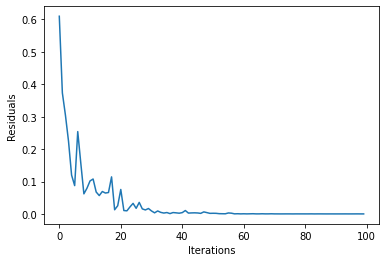

In [13]:
plt.plot(result.state.residuals)
plt.xlabel("Iterations")
plt.ylabel("Residuals")
plt.show()

In [14]:
lista = []
lista = result.state.residuals

In [15]:
result

optimal function value: 10.0
optimal value: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
status: INFEASIBLE

In [16]:
lista

[0.6096992809408945,
 0.3732216063364353,
 0.3043880480458213,
 0.22428305099434045,
 0.11970800071803893,
 0.08739854191575752,
 0.25400917499190284,
 0.1562220262604431,
 0.0620171787973071,
 0.07936372027748342,
 0.1018879868975986,
 0.1077632250948927,
 0.06762840769276134,
 0.056728405668505975,
 0.06923596141771968,
 0.06451171240530497,
 0.0661285494216822,
 0.11436587957991502,
 0.01294687404440503,
 0.02534686343821916,
 0.07551600643351214,
 0.010541408961255034,
 0.009670479028348,
 0.02185272066654344,
 0.03265912601365937,
 0.017360060146463685,
 0.035636999540483355,
 0.01566551053718067,
 0.01238163843677342,
 0.016785118816375275,
 0.009247292590995972,
 0.0035030305033382286,
 0.00926804444810925,
 0.004908330130517018,
 0.002815487186568646,
 0.004340559853011834,
 0.0011398330084615527,
 0.004310574168915432,
 0.0034571521773040753,
 0.002336338808999997,
 0.0041503806801725385,
 0.010580645373186459,
 0.002708469417020591,
 0.0032064565206686778,
 0.0034901727283878

In [17]:
import statistics
print(statistics.median(lista))

0.002030284042379186


In [18]:
result.state

<qiskit_optimization.algorithms.admm_optimizer.ADMMState at 0x7f139d9c9a10>

In [19]:
result.state.residuals

[0.6096992809408945,
 0.3732216063364353,
 0.3043880480458213,
 0.22428305099434045,
 0.11970800071803893,
 0.08739854191575752,
 0.25400917499190284,
 0.1562220262604431,
 0.0620171787973071,
 0.07936372027748342,
 0.1018879868975986,
 0.1077632250948927,
 0.06762840769276134,
 0.056728405668505975,
 0.06923596141771968,
 0.06451171240530497,
 0.0661285494216822,
 0.11436587957991502,
 0.01294687404440503,
 0.02534686343821916,
 0.07551600643351214,
 0.010541408961255034,
 0.009670479028348,
 0.02185272066654344,
 0.03265912601365937,
 0.017360060146463685,
 0.035636999540483355,
 0.01566551053718067,
 0.01238163843677342,
 0.016785118816375275,
 0.009247292590995972,
 0.0035030305033382286,
 0.00926804444810925,
 0.004908330130517018,
 0.002815487186568646,
 0.004340559853011834,
 0.0011398330084615527,
 0.004310574168915432,
 0.0034571521773040753,
 0.002336338808999997,
 0.0041503806801725385,
 0.010580645373186459,
 0.002708469417020591,
 0.0032064565206686778,
 0.0034901727283878

[0.00012141369162106502,
 0.0001598523981620667,
 0.0001363096183023072,
 0.00013366164218028267,
 0.00019449940125445926,
 0.00024421444450206735,
 0.00025167611916002527,
 0.00021537106591262232,
 0.00017643815976730237,
 0.00020383167704402593,
 0.00020170300246574247,
 0.000206931492765146,
 0.00018333844684891904,
 0.00021713388762022385,
 0.00020994328184666586,
 0.00024296944946516823,
 0.00024457664693026417,
 0.0002482295854048988,
 0.00018674532898820407,
 0.00019769590967444976,
 0.00019411858974276858,
 0.00024375739869511538,
 0.0002089992531592181,
 0.00020951181251973,
 0.0002483011004500093,
 0.0002250386902197582,
 0.00016766718356675924,
 0.00018897679470788073,
 0.00021242228282042198,
 0.00016713528881829182,
 0.00018282550408267565,
 0.00020721244869612994,
 0.00021869402792425632,
 0.00022081927154776182,
 0.00022754474554158595,
 0.00020706677412881896,
 0.00022560653748116146,
 0.00019025344701929618,
 0.0002385655425094464,
 0.00021635261763172078,
 0.00015843035492153822,
 0.00023195609359490414,
 0.0001720417937579681,
 0.0002204567297929457,
 0.00020705422902170338,
 0.00022724698997758188,
 0.0001886879055553237,
 0.00016933489224124583,
 0.00023193334781205417,
 0.00024620261401048693,
 0.00021665867994080212,
 0.00017219817427995945,
 0.0002075162072621998,
 0.00019728938796329234,
 0.0002028710199885681,
 0.0002199754406369366,
 0.00021008534603531942,
 0.0002331317949101826,
 0.00018383408521425608,
 0.00016520636586350823,
 0.00017108218707767957,
 0.00020963499258483986,
 0.0002223718285616617,
 0.0001977060669191568,
 0.00021587937372126003,
 0.0002284688515442429,
 0.00024385221917543986,
 0.00022164365397135498,
 0.0002339541056982006,
 0.00023184329593895061,
 0.00019166237528336544,
 0.00012148903950409603,
 0.0002023643240921501,
 0.00020890726059580848,
 0.00017840574866187555,
 0.00023026937836401358,
 0.0002077260937902401,
 0.0002160060175027085,
 0.00020155481028227344,
 0.00016570810369272447,
 0.0002154519837066465,
 0.0002047177186078402,
 0.00022776723077289258,
 0.0002004791382536291,
 0.00019532522431252858,
 0.0001965864008870737,
 0.00024713351166330756,
 0.0002225147745767656,
 0.00023356609090968112,
 0.00018672295206642652,
 0.00017706244697246435,
 0.0002312611336018245,
 0.00016143810647910342,
 0.00017801328530882057,
 0.00023217463560229267,
 0.00016807407152833376,
 0.00019893348274143088,
 0.00018770003833946695,
 0.00013960812242918945,
 0.0001762894637224225]

##Quantum Solution ????

NameError: ignored

In [20]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright